In [1]:
function extract_J(V,W)

    coshu = sqrt(V*V');
    exp_phi = inv(coshu) * V;

    F, coshr, X = svd(coshu);

    nel = length(coshr);
    r = zeros(nel);

    for i in 1:nel
        if abs(coshr[i]  - 1.0) < 1.0e-5
            coshr[i] = 1.0;3
        end
        r[i] = acosh(coshr[i]);
    end

    #check that X=F
    Fcheck = sum(sum(F - X));

    if abs(Fcheck)>1.0e-12
        println("F neq X");
    end

    sinhr = sinh.(r);

    Kinv_eig = zeros(nel);
    K_eig = zeros(nel);

    for i in 1:nel
        if r[i] < 1e-12
            Kinv_eig[i] = 1.0;
            K_eig[i] = 1.0;
        else
            Kinv_eig[i] = r[i]/sinhr[i];
            K_eig[i] = sinhr[i]/r[i];
        end
    end

    Kinv = F*diagm(Kinv_eig)*F';
    K = F*diagm(K_eig)*F';

    J = Kinv*(W*transpose(exp_phi));

    return J, exp_phi, r;

end


extract_J (generic function with 1 method)

In [2]:

function nonlinear_coeff(args, x1,x2, t)

    vg = args[1];
    P1 = args[2];
    P2 = args[3];
    R = args[4];
    gnl = args[5];
    Q = args[6];
    wP1 = args[7];
    wP2 = args[8];
    L = args[9];
    GammaP = args[10];
    T = args[11];

    N1 = length(x1);
    N2 = length(x2);
    Z = zeros(Complex{Float64},N1,N2);


    if abs(t) > 0.5 * T     #if the time is outside of the time that the c.w. pump is on, then the nonlinear parameter is zero

        return Z;

    else #then the pump is on and we have to calculate the nonlinear parameter

        mfact = -8.0*vg^3*sqrt(P1*P2)*gnl*eta^2*Q^2/(pi*2*pi*R*L*wP1*wP2);

        for idx1 in 1:N1
            arg1 = x1[idx1];
    
            for idx2 in 1:N2
                arg2 = x2[idx2];
        
                Z[idx1,idx2] = 1/(arg1 - 1im) * 1/(arg2-1im) * exp(1im*(arg1+arg2)*t);
    
            end
        end
    
        return mfact*Z;

    end

   

end


nonlinear_coeff (generic function with 1 method)

In [3]:
function solve_ode(V0, W0, args, x1, x2, tspan)
    Nt = length(tspan);
    dt = abs(tspan[2]-tspan[1]) / GammaP;
    for idx1 in 1:Nt

        t = tspan[idx1];

        Z = nonlinear_coeff(args, x1, x2, t);

        V0 = V0 - dt*2im*Z*conj(W0);
        W0 = W0 - dt*2im*Z*conj(V0);


    end

    return V0, W0;
end

solve_ode (generic function with 1 method)

[ Info:  started timer at: 2024-02-02T10:47:54.174
[ Info:         61.106880459s: 1 minute, 1 second, 106 milliseconds


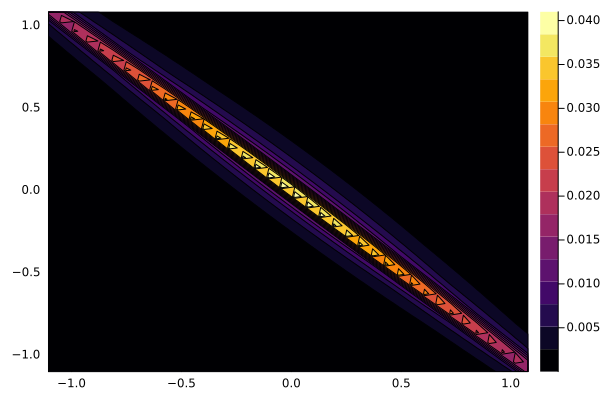

In [5]:
#This script will calculate the squeezing and rotation parameters of the squeezed state at the final time.
#this is generated by SFWM in a ring resonator point-coupled to a channel.
#I assume that there are two countinuous wave pump fields, that turn on at the time t = -T/2 and turn off at the time t = +T/2


using DifferentialEquations
using LinearAlgebra
using Plots; 
using TickTock

c = 299792458;
hbar = 1.05457182e-34;
gamma_nl = 1.0; #nonlinear parameter for SiN units of (Wm)^-1
eta = 0.8; #coupling efficiency to the real channel
Q = 2.0e5; #loaded quality factor
R = 100.0e-6; #ring radius
neff = 1.8; #effective index for SiN around 1550 nm
ng = 2.1; #group index for SiN around 1550 nm
vg = c/ng; #group velocity
fsr = vg/(2*pi*R); #free spectral range
TR = 2*pi*R*neff/c; #ring round trip time
lambdaS = 1550.0e-9; #wavelength for squeezed light
fS = c/lambdaS; #frequency of squeezed light
f1 = fS - fsr; #frequency of pump 1
f2 = fS + fsr; #frequency of pump 2
wP1 = 2*pi*f1; # angular frequency of pump 1
wP2 = 2*pi*f2; # angular frequency of pump 2
lambda1 = c/f1; #wavelength of pump 1
lambda2 = c/f2; #wavelength of pump 2
P1_peak = (1/2)*30.0e-3; #power of pump 1
P2_peak = 30.0e-3; #power of pump 2
dl = 0.005e-9; #wavelength stepsize around the resonances
L = 5.0; #discretization length for k-vectors
omegaS = 2*pi*fS; #angular frequency of squeezed light
GammaS = omegaS/(2*Q); #decay rate for squeezed light
GammaP = (wP1+wP2)/(4*Q); #average decary rate for pumps
KS = 2*pi*neff/lambdaS; #center k for squeezed light
kS_max = 2*pi*neff/(lambdaS-dl); #max k for squeezed light
kS_min = 2*pi*neff/(lambdaS+dl); #min k for squeezed light
dk = 2*pi/L; #spacing between k's
k1 = collect(kS_min:dk:kS_max); #array of k's for squeezed light
k2 = collect(kS_min:dk:kS_max);#array of k's for squeezed light
x1 = vg*(k1 .- KS)/GammaS; #dimensionless parameter for squeezed light
x2 = vg*(k2 .- KS)/GammaS; #dimensionless parameter for squeezed light

N1 = length(x1);
N2 = length(x2);

#set up time array
tbar_min = -100.0; #very early time  when there is no nonlinear interaction
tbar_max = 100.0; #very late time when there is no nonlinear interaction
dtbar = 0.001;
tspan = collect(tbar_min:dtbar:tbar_max);
T = 100.0; #time that the c.w. pump fields are on for. If T is large, then the pump is approx. c.w.. Here we have T ~ 33 ns

#collect all the arguments for the functions in an array
args = [vg, P1_peak, P2_peak, R, gamma_nl, Q, wP1, wP2, L, GammaP, T];

#initial matrices for V and W  at t = 0
V0 = Matrix{Float64}(I,N1,N2);
W0 = zeros(N1,N2);

#solve the ODEs for V and W. Also measure how long it takes. 
tick()
V1, W1 = solve_ode(V0,W0,args, x1, x2,tspan);
tock()

#check that the two contraints are satisfied
check1 = V1*V1' - W1*W1';
check2 = V1*transpose(W1) - W1*transpose(V1);

#extract the parameters of the squeezed state
J, exp_phi, r = extract_J(V1, W1);

#do a contour plot of the squeezing matrix J at the final time
# versus the dimensionless parameters x1 and x2.
contourf(x1,x2,abs.(J))
